In [1]:
# IMPORTS
import re
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, Subset
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel, TrainingArguments, Trainer

In [2]:
#DIRECTORIES
DATA_PATH = "../input/harry-potter-lstm/Harry_Potter_all_books.txt"
SAVED_MODEL_PATH = "/kaggle/input/harry-potter-text-generator-transformers/weights/checkpoint-57790"

In [3]:
#Load the file
text = open(DATA_PATH, "r", encoding="utf-8").read().lower()
sentences = re.split('[.!?]', text)

93.0


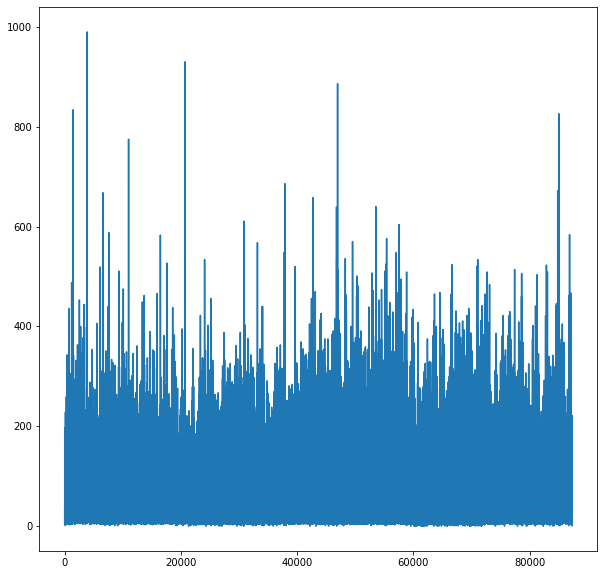

In [72]:
lenghts = [len(sentence) for sentence in sentences]
print(np.percentile(lenghts, 75))

plt.figure(figsize=(10,10))
plt.plot(lenghts)
plt.show()

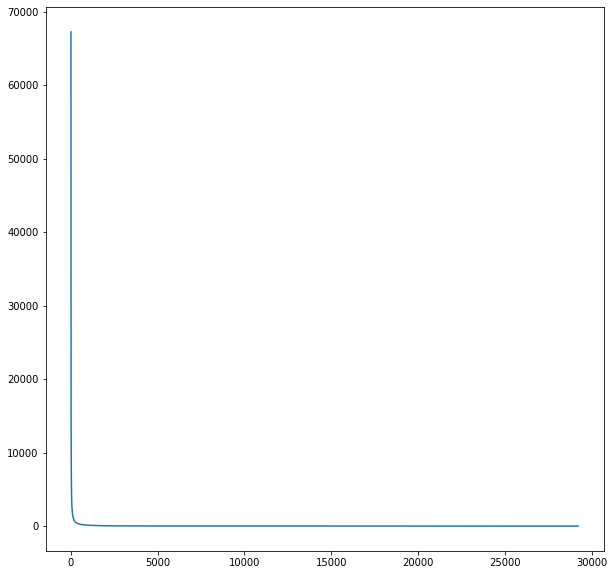

In [13]:
words = text.split()
words_unique = Counter(words).most_common()
dictionary = {}
for word in words_unique:
    dictionary[word[0]] = word[1]
dict_values = list(dictionary.values())

plt.figure(figsize=(10,10))
plt.plot(dict_values)
plt.show()

In [4]:
#Transformers
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained(SAVED_MODEL_PATH, local_files_only=True)
#model = AutoModelForCausalLM.from_pretrained("distilgpt2") #weights for fine tuning

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [5]:
tokenizer.pad_token = tokenizer.eos_token
data_token = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=85)

In [6]:
MAX_LENGTH = 85

class Harry_dataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for sentence in sentences:
            encodings_dict = tokenizer('<|startoftext|>' + sentence + '<|endoftext|>', truncation=True,
                                       max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
    

dataset = Harry_dataset(sentences, tokenizer, max_length=MAX_LENGTH)
train_size = int(0.9 * len(dataset))
train_dataset = Subset(dataset, list(range(0, train_size)))
val_dataset = Subset(dataset, list(range(train_size, len(dataset))))

In [25]:
training_args = TrainingArguments(output_dir='./weights', num_train_epochs=5, logging_steps=500,
                                  evaluation_strategy='steps', logging_strategy='steps', save_strategy='epoch',
                                  per_device_train_batch_size=32, per_device_eval_batch_size=32,
                                  warmup_steps=10, save_total_limit=1, weight_decay=0.05, report_to='none')

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices


In [24]:
Trainer(model=model,  args=training_args, train_dataset=train_dataset, 
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 78560
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4910


Step,Training Loss,Validation Loss
500,0.439900,0.926319
1000,0.474500,0.903687
1500,0.510000,0.887941
2000,0.550700,0.861778
2500,0.588100,0.869580
3000,0.531100,0.866913
3500,0.550900,0.849393
4000,0.577000,0.836546
4500,0.614500,0.823675


***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
Saving model checkpoint to ./weights/checkpoint-2455
Configuration saved in ./weights/checkpoint-2455/config.json
Model weights saved in ./weights/checkpoint-2455/pytorch_model.bin
Deleting older checkpoint [weights/checkpoint-4910] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8729
  Batch size = 32
Saving model checkpoint to ./weights/checkpoint-4910
Configuration saved in ./weights/checkpoint-49

TrainOutput(global_step=4910, training_loss=0.5456204478463913, metrics={'train_runtime': 1512.289, 'train_samples_per_second': 103.895, 'train_steps_per_second': 3.247, 'total_flos': 3407881214361600.0, 'train_loss': 0.5456204478463913, 'epoch': 2.0})

In [ ]:
0,65

In [21]:
begin = 'Harry used to live under staircase but now'
generated = tokenizer.encode(begin, return_tensors='pt').cuda()
attention_mask = torch.ones_like(generated)
sample_outputs = model.generate(generated, do_sample=True, top_k=10, max_new_tokens=200, min_length=100, top_p=0.95, temperature=1.5, no_repeat_ngram_size=3, attention_mask=attention_mask, pad_token_id=tokenizer.eos_token_id)[0]
tokenizer.decode(sample_outputs, skip_special_tokens=True)

'Harry used to live under staircase but now see who is  but not a wizard at hogwarts  he said in his cold voice ive seen  the dementors have been attacked so long since ive been attacked by these dementors  that they are only too young to be killed to be brought by a man with a man or a girl  he added quickly to harrys mother and sister to harry  i know who said dobby   what we didnt youve got youd think he was talking about '

In [ ]:
#compress folder to zip file
import shutil
shutil.make_archive("GPT2_weights", 'zip', "./checkpoint-25000")